c:\Users\uqkmuroi\gitcode\Torch-Practice\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Iter 1/100 - Loss: 3.117056369781494
Iter 11/100 - Loss: 1.9507899284362793
Iter 21/100 - Loss: 1.6558506488800049
Iter 31/100 - Loss: 1.519714117050171
Iter 41/100 - Loss: 1.4198353290557861
Iter 51/100 - Loss: 1.3154563903808594
Iter 61/100 - Loss: 1.2265968322753906
Iter 71/100 - Loss: 1.1590238809585571
Iter 81/100 - Loss: 1.1038295030593872
Iter 91/100 - Loss: 1.0707286596298218
Mean predictions: tensor([1.6381, 2.6235, 3.7169])
Confidence region: tensor([1.4893, 2.4735, 3.5682]) to tensor([1.7869, 2.7736, 3.8657])


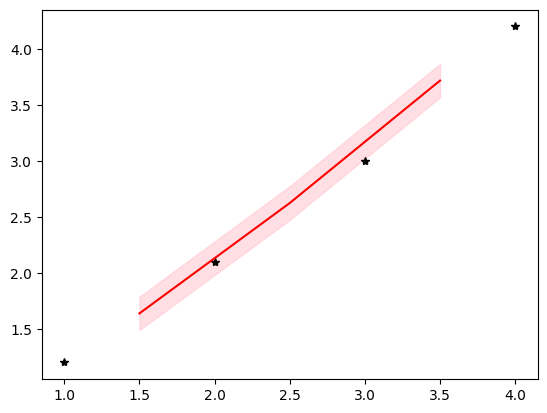

In [1]:
# Basic Gaussian Process Regression with GPyTorch NOISE!!!!

import torch
import gpytorch
from matplotlib import pyplot as plt

# Define the model class
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()
        
    def forward(self, x):
        # Define the GP forward pass
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

# Training data
train_x = torch.tensor([[1.0], [2.0], [3.0], [4.0]], dtype=torch.float32)
train_y = torch.tensor([1.2, 2.1, 3.0, 4.2], dtype=torch.float32)
train_y_noisy = train_y + torch.normal(0, 0.1, size=train_y.shape)  # Add noise

# Likelihood models the observation noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Initialize the model
model = GPModel(train_x, train_y_noisy, likelihood)

# Set the model into training mode
model.train()
likelihood.train()

# Define the optimizer and loss function
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  
], lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop
for i in range(100):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y_noisy)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f'Iter {i + 1}/100 - Loss: {loss.item()}')

# After training, set the model into evaluation mode
model.eval()
likelihood.eval()

# Make predictions on test data
test_x = torch.tensor([[1.5], [2.5], [3.5]], dtype=torch.float32)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = model(test_x)
    mean = pred.mean
    lower, upper = pred.confidence_region()

# Print results
print(f'Mean predictions: {mean}')
print(f'Confidence region: {lower} to {upper}')

# Plot results
plt.plot(train_x.numpy(), train_y.numpy(), 'k*')
plt.plot(test_x.numpy(), mean.numpy(), 'r')
plt.fill_between(test_x.numpy().flatten(), lower.numpy().flatten(), upper.numpy().flatten(), color='pink', alpha=0.5)
plt.show()
